# Сегментация клиентской базы телекоммуникационной компании

**Аналитическая задача** — провести анализ данных с целью выделения наиболее типичных групп клиентов и разработки предложений для каждой из групп.

## Описание данных
Каждый клиент описывается следующим набором признаков:
- `Возраст`, `Среднемесячный расход`, `Средняя продолжительность разговоров`, `Звонков днем за месяц`, `Звонков вечером за месяц`, `Звонков ночью за месяц`, `Звонки в другие города`, `Звонки в другие страны`, `Доля звонков на стационарные телефоны`, `Количество SMS за месяц`, `Дата подключения тарифа`.

## Примерный план по выполнению проекта

**Шаг 1.** Загрузка данных;

**Шаг 2.** Первичная обработка данных (при необходимости):
- скорректировать заголовки;
- скорректировать типы признаков;
- проверить наличие дублирующихся записей;
- проверить наличие аномальных значений;
- восстановить пропущенные значения;

**Шаг 3.** Добавление новых переменных:
- по значениям признака `Возраст` введите новую переменную `Возрастная категория`, принимающую значения "студент", "аспирант", "бизнесмен" и "знаток" по следующую правилу:

$$
\text{Возрастная категория} = 
\left\{
\begin{array}{l}
\text{студент,} \quad \text{если Возраст } \in [19, 24];\\  
\text{аспирант,} \quad \text{если Возраст } \in [25, 33];\\
\text{бизнесмен,} \quad \text{если Возраст } \in [34, 56];\\
\text{знаток,} \quad \text{если Возраст } \in [57, 70].
\end{array}
\right.
$$ 

- по значениям признака `Дата подключения тарифа` создайте признаки: `Год подключения`, `Месяц подключения`, `Дата подключения`;  

**Шаг 3.** Провести исследовательский анализ данных:
- в разрезе значений признаков `Год подключения`, `Месяц подключения`, `Дата подключения` исследуйте:
    - динамику подключения к тарифам (количество клиентов). Постройте графики. В какой год, месяц и день подключались меньше/больше всего клиентов? Какие выводы можно сделать?
- в разрезе значений признака `Возрастная категория` исследуйте распределение признаков `Среднемесячный расход`, `Средняя продолжительность разговоров`, `Звонков днем за месяц`, `Звонков вечером за месяц`, `Звонков ночью за месяц`, `Звонки в другие города`, `Доля звонков на стационарные телефоны`, `Количество SMS за месяц`. Для каждого из признаков рассчитайте выборочное среднее, медиану и моду. Постройте графики. Какие выводы можно сделать о предпочтениях клиентов разных возрастных категорий в отношении используемых услуг (звонков и SMS; времени суток);
- клиенты каких возрастных категорий (ТОП-2):
  
    - больше всего в среднем в месяц тратят на оплату услуг связи;
    - больше всего тратят времени на общение в месяц днем, вечером и ночью;
    - больше всего по количеству звонков в месяц днем, вечером и ночью. Совпадают ли результаты с предыдущем пунктом;

- с помощью диаграмм рассеивания исследуейте зависимости между признаками `Среднемесячный расход`, `Средняя продолжительность разговоров`, `Звонков днем за месяц`, `Звонков вечером за месяц`, `Звонков ночью за месяц`, `Звонки в другие города`, `Доля звонков на стационарные телефоны`, `Количество SMS за месяц`. Какие выводы можно сделать?

## Подключение библиотек

In [216]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import datetime as dt

# Блок функций

In [217]:
def delete_apost(df_column: pd.Series) -> float:
    """
    Функция для корректировки значений признака, содержащих апострофы.

    Args:
    df_column -- pd.Series -- столбец DataFrame

    Return:
    Для каждого значения столбца возвращает его вещественное представление
    """

    if df_column.isdigit():
        return float(df_column)
    else:
        return float(df_column.replace("'",""))


def calc_boxplot(df_col : pd.Series) -> tuple:

    """
    Функция для расчета значений нижнего и верхнего усов.
    На вход подается столбец датафрейма,
    на выходе кортеж: первый элемент -- нижний ус, второй элемент -- верхний ус
    """

    Q1, median, Q3 = np.percentile(np.asarray(df_col.dropna()), [25, 50, 75])
    IQR = Q3 - Q1
    loval = Q1 - 1.5 * IQR
    hival = Q3 + 1.5 * IQR
    wiskhi = np.compress(np.asarray(df_col.dropna()) <= hival, np.asarray(df_col.dropna()))
    wisklo = np.compress(np.asarray(df_col.dropna()) >= loval, np.asarray(df_col.dropna()))
    actual_hival = np.max(wiskhi)
    actual_loval = np.min(wisklo)
    return actual_loval, actual_hival #(нижний ус, верхний ус)


def get_status(x):
    """
    Функция для определения возрастной категории клиента по возрасту.
    
    Классификация осуществляется по следующим правилам:
    - 19-24 года: 'студент'
    - 25-33 года: 'аспирант' 
    - 34-56 лет: 'бизнесмен'
    - 57-70 лет: 'знаток'
    
    Args:
        age (int): Возраст клиента в годах
        
    Returns:
        str: Возрастная категория клиента
    """
    if (x>=19) & (x<=24):
        return 'студент'
    elif (x>=25) & (x<=33):
        return 'аспирант'
    elif (x>=34) & (x<=56):
        return 'бизнесмен'
    elif (x>=57) & (x<=70):
        return 'знаток'    

def plot_some_feature(lst_col: list):
    """
    Функция для визуализации распределений признаков из переданного списка.
    
    Для каждого признака строит два графика:
    1. Boxplot с отображением 1-го и 99-го перцентилей, а также границ усов
    2. Гистограмма с ядерной оценкой плотности (KDE) и теми же перцентилями/усами
    
    Args:
        lst_col (list): Список названий столбцов DataFrame для визуализации
        
    Returns:
        None: Функция отображает графики, но не возвращает значений
        
    Note:
        Использует глобальную переменную df и функцию calc_boxplot для расчета границ усов
    """
    
    plt.subplots(5, 2, figsize=(12, 24), gridspec_kw={'wspace': 0.3, 'hspace': 0.3})
    for index, col in enumerate(lst_col):

        # для каждого признака рассчитаем
        # нижняя и верхняя границы boxplot'а
        low_wish, hi_wish = calc_boxplot(df[col])
        # 1-ая перцентиль
        per_1 = np.nanpercentile(df[col], 1)
        # 99-ая перцентиль
        per_99 = np.nanpercentile(df[col], 99)

        # boxplot признака
        plt.subplot(5,2, 2*index+1)
        ax_1 = sns.boxplot(df[col]);
        plt.xlabel(f'{col}')
        plt.ylabel('')
        plt.title(f'Boxplot для признака \n <<{col}>>')

        # визуализация перцентилей
        ax_1.axhline(per_1,
                    color='green',
                    linestyle='--',
                    label=f'{np.round(per_1,1)} значение 1-го перцентиля')
        ax_1.axhline(per_99,
                    color='red',
                    linestyle='--',
                    label=f'{np.round(per_99,1)} значение 99-го перцентиля')
        # визуализация усов
        ax_1.axhline(low_wish,
                    color='yellow',
                    linestyle='--',
                    label=f'{np.round(low_wish,1)} значение нижнего уса')

        ax_1.axhline(hi_wish,
                    color='blue',
                    linestyle='--',
                    label=f'{np.round(hi_wish,1)} значение верхнего уса')
        plt.legend(loc=1, fontsize=6)

        # гистограмма признака
        plt.subplot(5,2, 2*index+2)
        ax_2 = sns.histplot(df[col],
                            kde=True);
        plt.xlabel(f'{col}')
        plt.ylabel('Частота')
        plt.title(f'Гистограмма для признака \n <<{col}>>')

        # визуализация перцентилей
        ax_2.axvline(per_1,
                    color='green',
                    linestyle='--',
                    label=f'{np.round(per_1,1)} значение 1-го перцентиля')
        ax_2.axvline(per_99,
                    color='red',
                    linestyle='--',
                    label=f'{np.round(per_99,1)} значение 99-го перцентиля')
        # расчет и визуализация усов
        ax_2.axvline(low_wish,
                    color='yellow',
                    linestyle='--',
                    label=f'{np.round(low_wish,1)} значение нижнего уса')

        ax_2.axvline(hi_wish,
                    color='blue',
                    linestyle='--',
                    label=f'{np.round(hi_wish,1)} значение верхнего уса')
        plt.legend(loc=1, fontsize=6)

def calc_mode(series):
    """
    Функция для расчета моды признака.
    
    Args:
        series (pd.Series): Столбец данных
        
    Returns:
        float/int: Мода или NaN, если мода отсутствует
    """
    return series.mode().iloc[0] if not series.mode().empty else np.nan    

# Загрузка и ознакомление с данными

In [218]:
# загрузка данных
df = pd.read_csv('/Users/user/Desktop/Аналитик данных/project_2/dataset_telecom.csv')

In [219]:
# просмотр датафрейма
df.head(2)

Возраст  Среднемесячный расход  Средняя продолжительность разговоров  \
0       24                    NaN                                   2.4   
1       51                 287.51                                   1.7   

   Звонков днем за месяц  Звонков вечером за месяц Звонков ночью за месяц  \
0                   12.0                      65.0                      5   
1                  111.0                     109.0                      1   

  Звонки в другие города  Звонки в другие страны  \
0                      0                       0   
1                     44                       0   

  Доля звонков на стационарные телефоны Количество SMS за месяц  \
0                                     5                      56   
1                                     6                       1   

  Дата подключения тарифа  
0     2018-06-17 12:14:35  
1     2021-10-21 15:39:54

In [220]:
# просмотр информации о типах данных
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4492 entries, 0 to 4491
Data columns (total 11 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Возраст                                4492 non-null   int64  
 1   Среднемесячный расход                  4468 non-null   float64
 2   Средняя продолжительность разговоров   4475 non-null   float64
 3   Звонков днем за месяц                  4472 non-null   float64
 4   Звонков вечером за месяц               4489 non-null   float64
 5   Звонков ночью за месяц                 4492 non-null   object 
 6   Звонки в другие города                 4492 non-null   object 
 7   Звонки в другие страны                 4492 non-null   int64  
 8   Доля звонков на стационарные телефоны  4492 non-null   object 
 9   Количество SMS за месяц                4492 non-null   object 
 10  Дата подключения тарифа                4492 non-null   object 
dtypes: f

In [221]:
# просмотр описательных статистик

perc = [0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99]
df.describe(percentiles=perc)

Возраст  Среднемесячный расход  \
count  4492.000000            4468.000000   
mean     41.894924             505.533577   
std      13.077254             646.354693   
min      19.000000               3.180000   
1%       19.000000               7.790100   
5%       20.000000              16.800000   
25%      31.000000             152.490000   
50%      43.000000             315.510000   
75%      52.000000             599.840000   
95%      63.000000            1610.304500   
99%      69.000000            3544.902900   
max      70.000000            5142.760000   

       Средняя продолжительность разговоров  Звонков днем за месяц  \
count                           4475.000000            4472.000000   
mean                               4.230827              63.899374   
std                                3.005210              62.877394   
min                                0.100000               1.000000   
1%                                 0.400000               2.000000   
5%                                 1.100000               5.000000   
25%                                2.100000              37.000000   
50%                                3.300000              53.000000   
75%                                5.900000              68.000000   
95%                                9.700000             133.000000   
99%                               14.452000             391.160000   
max                               20.000000             500.000000   

       Звонков вечером за месяц  Звонки в другие страны  
count               4489.000000             4492.000000  
mean                  70.363778                0.394034  
std                   41.219909                1.171980  
min                    1.000000                0.000000  
1%                     2.000000                0.000000  
5%                     4.000000                0.000000  
25%                   42.000000                0.000000  
50%                   71.000000                0.000000  
75%                   98.000000                0.000000  
95%                  142.000000                2.000000  
99%                  156.000000                6.000000  
max                  160.000000               12.000000

## Выводы

данные загружены корректно;

обнаружены следующие особенности данных:

|Признак|Комментарий|
|--:|:--|
|`all`|сделать лаконичные заголовки|
|`Звонков ночью за месяц`, `Звонки в другие города`| для числовых признаков необходимо скорректировать тип данных|
|`Доля звонков на стационарные телефоны`, `Количество SMS за месяц`| |
|`Дата подключения тарифа`| для числовых признаков необходимо скорректировать тип данных|
|`Среднемесячный расход`| имеется небольшое количество пропущенных значений|
|`Средняя продолжительность разговоров`|имеется небольшое количество пропущенных значений|
|`Звонков днем за месяц`|имеется небольшое количество пропущенных значений|
|`Звонков вечером за месяц`|имеется небольшое количество пропущенных значений|
|`Среднемесячный расход`, `Звонков днем за месяц`| в ряде признаков присутствуют аномальные значения|
|`Звонки в другие страны`| значительное количество клиентов не пользуется услугами данного вида.|
|| Возможно следует выделить этих клиентов в отдельный набор|


# Предварительная обработка данных

## Корректировка заголовков

In [222]:
# лаконичные заголовки
new_columns = {'Возраст': 'возраст',
              'Среднемесячный расход': 'среднемесячный расход',
              'Средняя продолжительность разговоров': 'средняя продолжительность разговоров',
              'Звонков днем за месяц': 'звонки днем',
              'Звонков вечером за месяц': 'звонки вечером',
              'Звонков ночью за месяц': 'звонки ночью',
              'Звонки в другие города': 'звонки в другие города',
              'Звонки в другие страны': 'звонки в другие страны',
              'Доля звонков на стационарные телефоны': 'звонки на стационарные телефоны',
              'Количество SMS за месяц': 'количество смс',
              'Дата подключения тарифа': 'дата подключения'}
df.rename(columns=new_columns, inplace=True)

## Корректировка типов данных

In [223]:
# корректировка признака, содержащего дату и время
df = df.astype({'дата подключения': 'datetime64[s]'})

# проверка типов
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4492 entries, 0 to 4491
Data columns (total 11 columns):
 #   Column                                Non-Null Count  Dtype        
---  ------                                --------------  -----        
 0   возраст                               4492 non-null   int64        
 1   среднемесячный расход                 4468 non-null   float64      
 2   средняя продолжительность разговоров  4475 non-null   float64      
 3   звонки днем                           4472 non-null   float64      
 4   звонки вечером                        4489 non-null   float64      
 5   звонки ночью                          4492 non-null   object       
 6   звонки в другие города                4492 non-null   object       
 7   звонки в другие страны                4492 non-null   int64        
 8   звонки на стационарные телефоны       4492 non-null   object       
 9   количество смс                        4492 non-null   object       
 10  дата подключ

## Корректировка значений  признака

In [224]:
# корректировка значений отдельных признаков

# список признаков, значения которых содержат ошибки
lst_columns = ['звонки ночью', 'звонки в другие города',
               'звонки на стационарные телефоны',
               'количество смс']

for col in lst_columns:
    df[col] = df[col].apply(delete_apost)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4492 entries, 0 to 4491
Data columns (total 11 columns):
 #   Column                                Non-Null Count  Dtype        
---  ------                                --------------  -----        
 0   возраст                               4492 non-null   int64        
 1   среднемесячный расход                 4468 non-null   float64      
 2   средняя продолжительность разговоров  4475 non-null   float64      
 3   звонки днем                           4472 non-null   float64      
 4   звонки вечером                        4489 non-null   float64      
 5   звонки ночью                          4492 non-null   float64      
 6   звонки в другие города                4492 non-null   float64      
 7   звонки в другие страны                4492 non-null   int64        
 8   звонки на стационарные телефоны       4492 non-null   float64      
 9   количество смс                        4492 non-null   float64      
 10  дата подключ

## Поиск и обработка дублирующихся записей

In [225]:
print(f'В анализируемом наборе {df.duplicated().sum()} дублирующихся записей.')

В анализируемом наборе 0 дублирующихся записей.


## Поиск и обработка аномальных значений

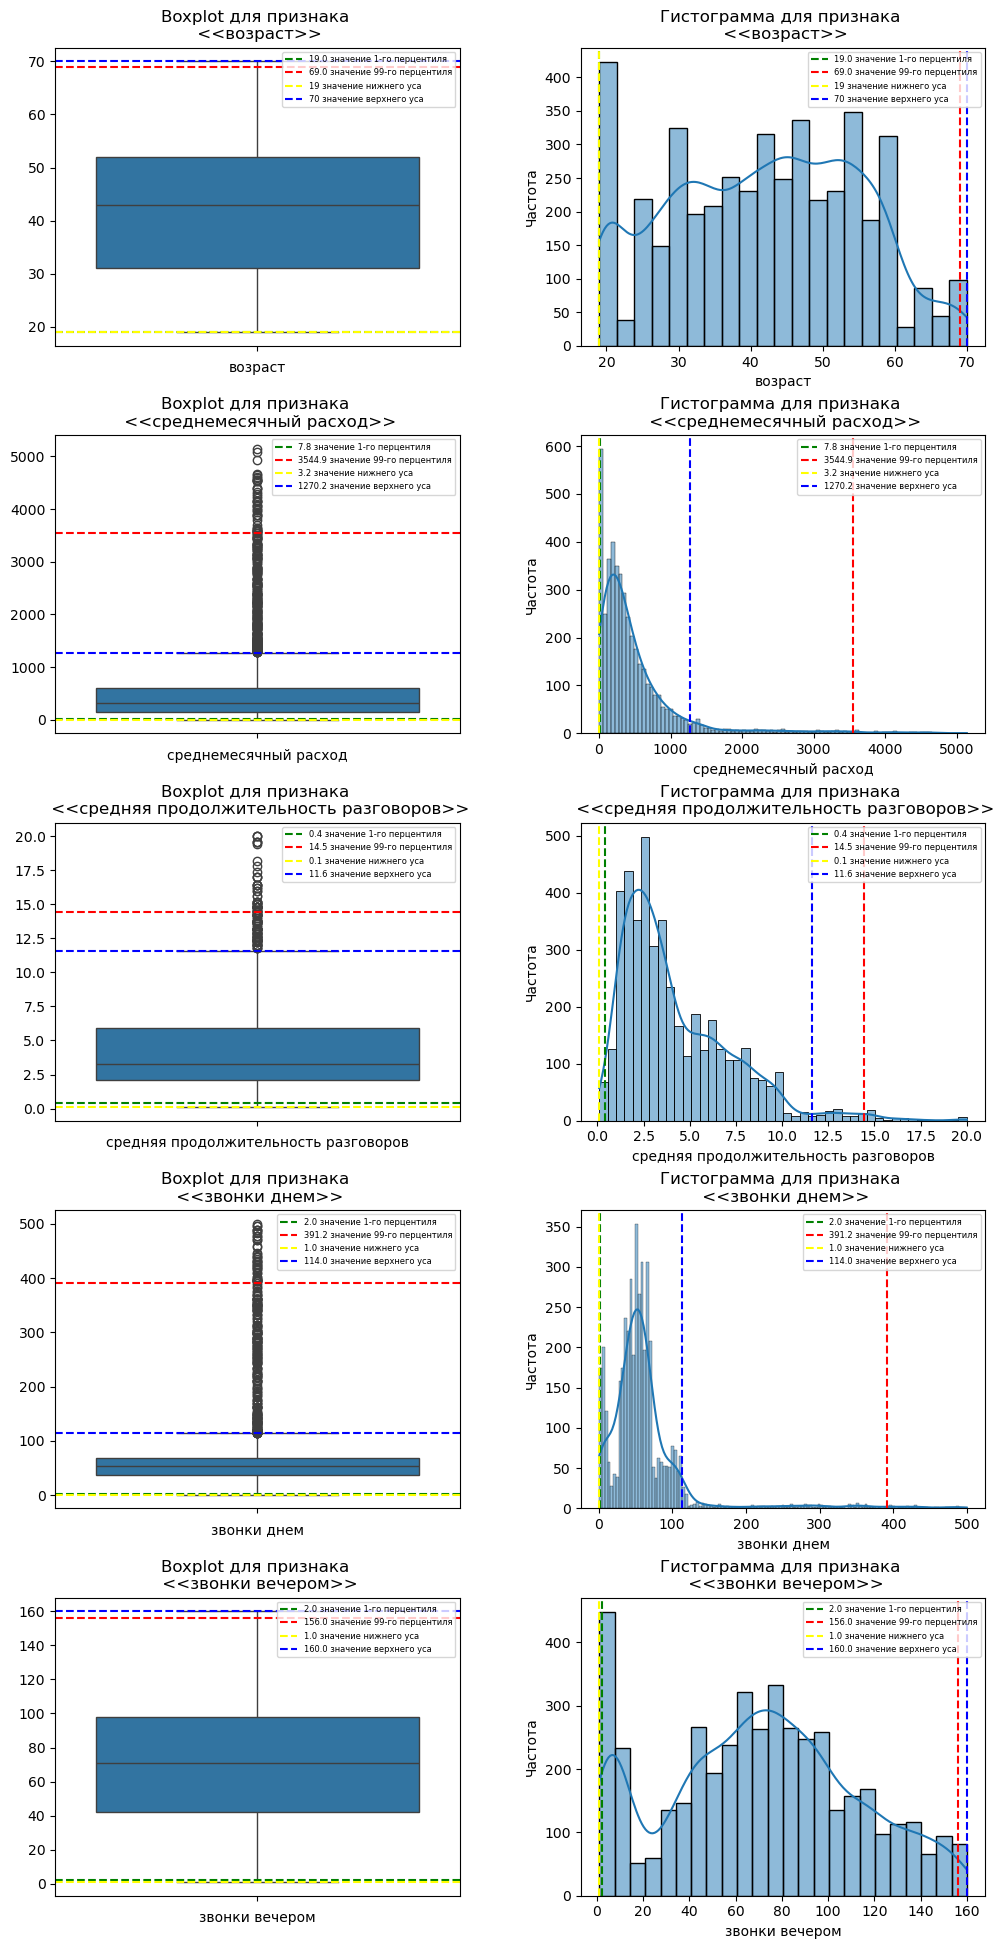

In [226]:
# список непрерывных признаков
lst_var_cont = ['возраст', 'среднемесячный расход',
                'средняя продолжительность разговоров',
                'звонки днем', 'звонки вечером', 'звонки ночью',
                'звонки в другие города', 'звонки в другие страны',
                'звонки на стационарные телефоны', 'количество смс']


# построим графики циклически для первых 5-ти признаков
plt.subplots(5,2, figsize=(12,24), gridspec_kw={'wspace': 0.3,
                                                'hspace': 0.3})
for index, col in enumerate(lst_var_cont[:5]):
    low_wish, hi_wish = calc_boxplot(df[col])
    per_1 = np.nanpercentile(df[col], 1)
    per_99 = np.nanpercentile(df[col], 99)

    # boxplot признака
    plt.subplot(5,2, 2*index+1)
    ax_1 = sns.boxplot(df[col]);
    plt.xlabel(f'{col}')
    plt.ylabel('')
    plt.title(f'Boxplot для признака \n <<{col}>>')

    # визуализация перцентилей
    ax_1.axhline(per_1,
                color='green',
                linestyle='--',
                label=f'{np.round(per_1,1)} значение 1-го перцентиля')
    ax_1.axhline(per_99,
                color='red',
                linestyle='--',
                label=f'{np.round(per_99,1)} значение 99-го перцентиля')
    # визуализация усов
    ax_1.axhline(low_wish,
                color='yellow',
                linestyle='--',
                label=f'{np.round(low_wish,1)} значение нижнего уса')

    ax_1.axhline(hi_wish,
                color='blue',
                linestyle='--',
                label=f'{np.round(hi_wish,1)} значение верхнего уса')
    plt.legend(loc=1, fontsize=6)

    # гистограмма признака
    plt.subplot(5,2, 2*index+2)
    ax_2 = sns.histplot(df[col],
                        kde=True);
    plt.xlabel(f'{col}')
    plt.ylabel('Частота')
    plt.title(f'Гистограмма для признака \n <<{col}>>')

    # визуализация перцентилей
    ax_2.axvline(per_1,
                color='green',
                linestyle='--',
                label=f'{np.round(per_1,1)} значение 1-го перцентиля')
    ax_2.axvline(per_99,
                color='red',
                linestyle='--',
                label=f'{np.round(per_99,1)} значение 99-го перцентиля')
    # расчет и визуализация усов
    ax_2.axvline(low_wish,
                color='yellow',
                linestyle='--',
                label=f'{np.round(low_wish,1)} значение нижнего уса')

    ax_2.axvline(hi_wish,
                color='blue',
                linestyle='--',
                label=f'{np.round(hi_wish,1)} значение верхнего уса')
    plt.legend(loc=1, fontsize=6)

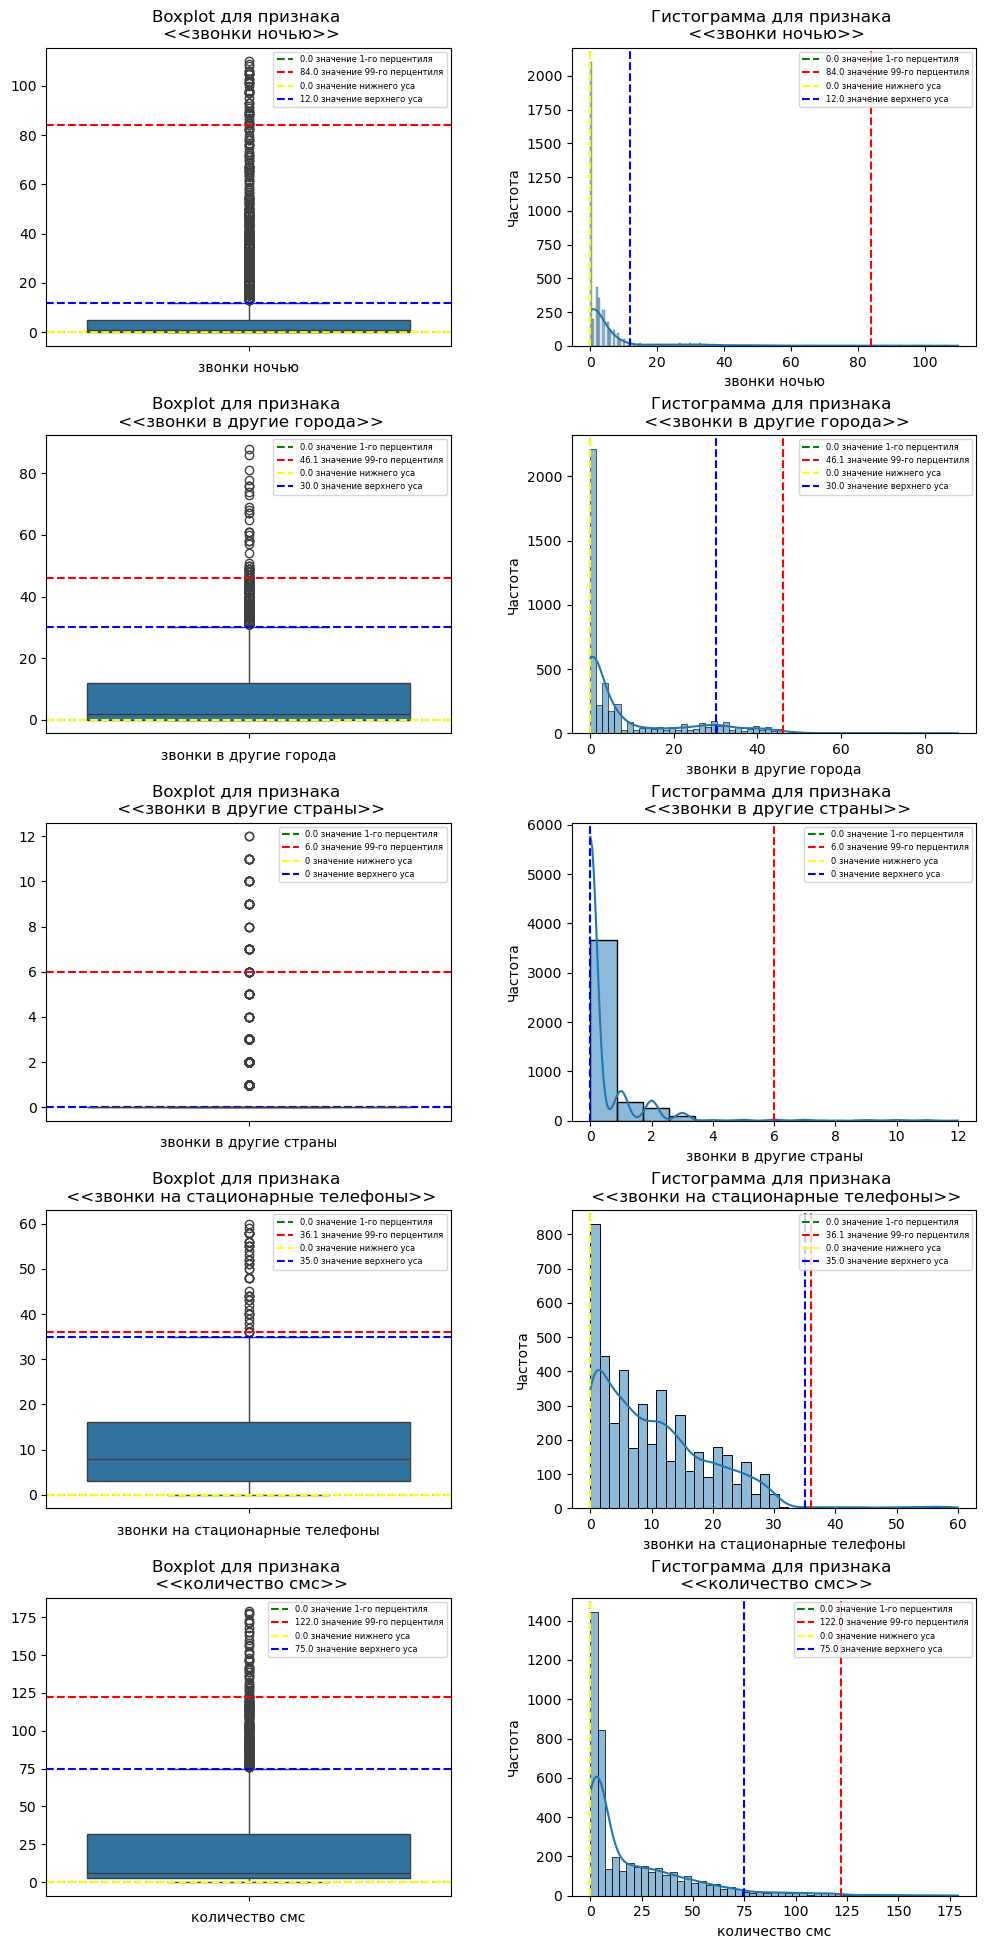

In [227]:
# построим графики циклически для оставшихся признаков
plot_some_feature(lst_var_cont[5:]) 


In [171]:
# Проанализировав построенные графики, составим фильтр для отсечения аномальных значений.
# В данном случае аномальные значения удаляться не будут, а далее исследуются отдельно
# В отдельный набор также будет веделены клиенты, пользующиеся услугами международной связи

# фильтр для значений, не являющихся аномальными
filt = (
    (df['среднемесячный расход'].between(calc_boxplot(df['среднемесячный расход'])[0],
                                         calc_boxplot(df['среднемесячный расход'])[1]))
    &
     (df['средняя продолжительность разговоров'].between(calc_boxplot(df['средняя продолжительность разговоров'])[0],
                                                          np.nanpercentile(df['средняя продолжительность разговоров'], 99)))
    &
     (df['звонки днем'].between(calc_boxplot(df['звонки днем'])[0], calc_boxplot(df['звонки днем'])[1]))
    &
     (df['звонки ночью'].between(calc_boxplot(df['звонки ночью'])[0], calc_boxplot(df['звонки ночью'])[1]))
    &
     (df['звонки в другие города'].between(calc_boxplot(df['звонки в другие города'])[0],
                                                         np.nanpercentile(df['звонки в другие города'], 99)))
    &
     (df['звонки на стационарные телефоны'].between(calc_boxplot(df['звонки на стационарные телефоны'])[0],
                                                          np.nanpercentile(df['звонки на стационарные телефоны'], 99)))
    &
     (df['количество смс'].between(calc_boxplot(df['количество смс'])[0],
                                         calc_boxplot(df['количество смс'])[1]))
)

In [172]:
# оценим процент потерь
print(f"Процент аномальных записей {(1 - df.loc[filt].shape[0]/df.shape[0]):.2%}.")

Процент аномальных записей 16.67%.


## Обработка пропущенных значений

In [173]:
# количество пропусков по признакам

df.isna().sum()

возраст                                  0
среднемесячный расход                   24
средняя продолжительность разговоров    17
звонки днем                             20
звонки вечером                           3
звонки ночью                             0
звонки в другие города                   0
звонки в другие страны                   0
звонки на стационарные телефоны          0
количество смс                           0
дата подключения                         0
dtype: int64

In [174]:
# есть некоторое незначительное кол-во пропущенных значений
# Удалим соответствущие записи (строки), содержащие пропуски
df.dropna(inplace=True)

## Выводы

Проведены следующие работы:
- скорректированы заголовки признаков;
- скорректированы значения отдельных признаков и типы данных соответствующих столбцов;
- дублирующихся записей нет;
- на основе анализа распределений непрерывных признаков относительно значений нижней и верхней границ boxplot'а, а также 1-ой и 99-ой перцентилей составлен фильтр для выявления аномальных значений;   
- набор содержал небольшое количество пропущенных значений, которые были удалены.   


# Добавление новых переменных

In [179]:
# добавление нового признака Статус
df['статус'] = df['возраст'].apply(get_status)

# создание новых признаков для даты:
df['год подключения'] = df['дата подключения'].dt.year
df['месяц подключения'] = df['дата подключения'].dt.month
df['день подключения'] = df['дата подключения'].dt.date

### Вывод

На этом этапе добавлены новые признаки.

# Исследовательский анализ данных

## Фильтрация данных

In [180]:
# для проведения EDA создадим несколько вспомогательных наборов

# аномальные данные
df_anomals = df.loc[~filt]
# очищенные данные
df_clients = df.loc[filt]
# международники
df_country = df[df['звонки в другие страны'] > 0]

## Исследование динамики количества подключений по годам, месяцам и дням

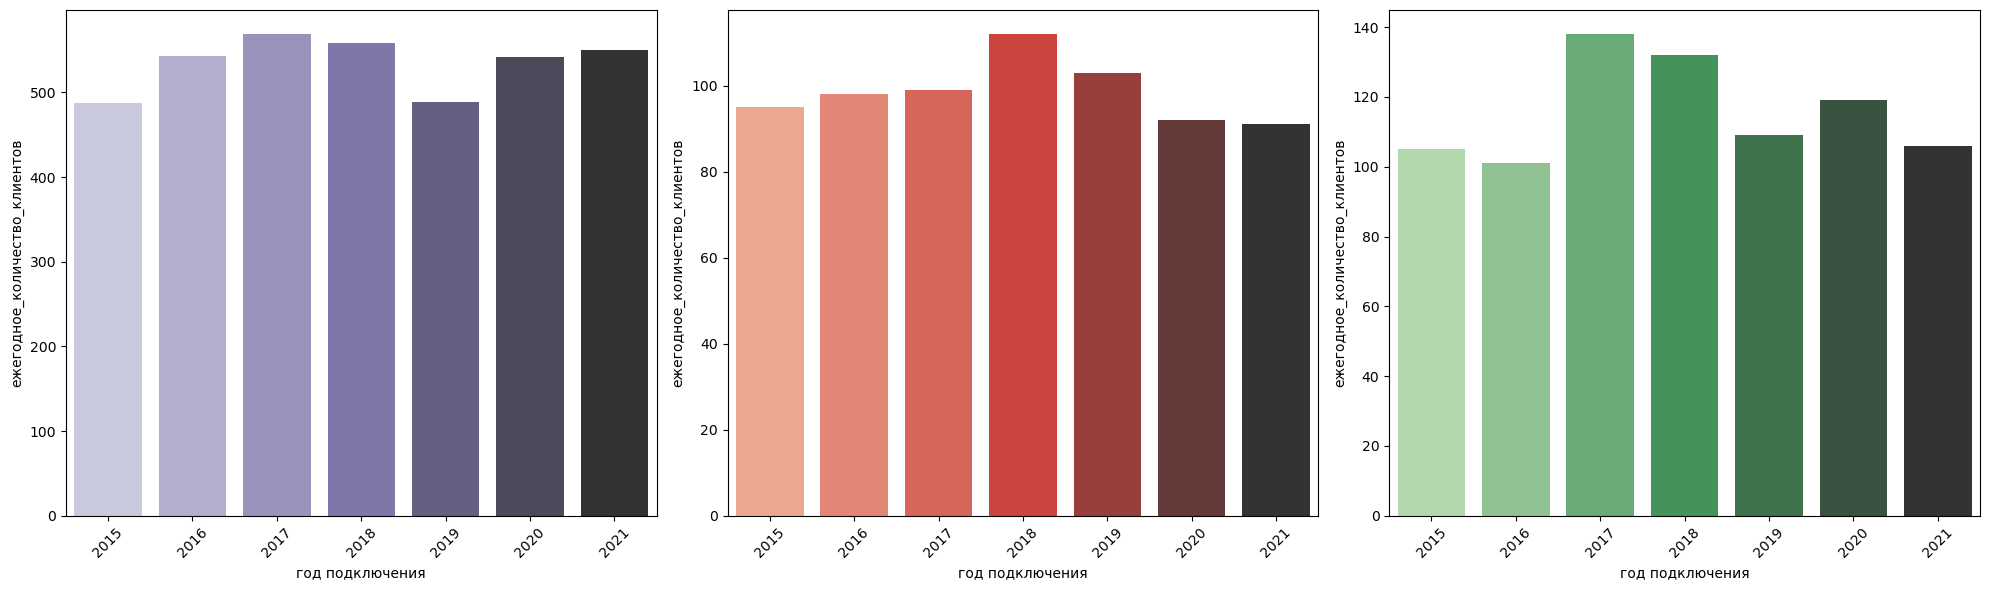

In [181]:
# в разрезе значений признаков Год подключения, Месяц подключения, Дата подключения исследуйте:
# динамику подключения к тарифам (количество клиентов). Постройте графики.
# В какой год и месяц подключались меньше/больше всего клиентов? Какие выводы можно сделать?
plt.figure(figsize=(20, 6))

plt.subplot(1, 3, 1)
df_year_clear = (
    df_clients.groupby('год подключения')
              .agg(ежегодное_количество_клиентов=('возраст', 'count'))
              .reset_index()
)
sns.barplot(x='год подключения', y='ежегодное_количество_клиентов', 
           hue='год подключения', data=df_year_clear, palette='Purples_d', legend=False)
plt.xlabel('год подключения')
plt.ylabel('ежегодное_количество_клиентов')
plt.xticks(rotation=45)

plt.subplot(1, 3, 2)
# для аномальных записей
df_year_anomals = (
    df_anomals.groupby('год подключения')
              .agg(ежегодное_количество_клиентов=('возраст', 'count'))
              .reset_index()
)
sns.barplot(x='год подключения', y='ежегодное_количество_клиентов', 
           hue='год подключения', data=df_year_anomals, palette='Reds_d', legend=False)
plt.xlabel('год подключения')
plt.ylabel('ежегодное_количество_клиентов')
plt.xticks(rotation=45)

plt.subplot(1, 3, 3)
# для международных записей
df_year_country = (
    df_country.groupby('год подключения')
              .agg(ежегодное_количество_клиентов=('возраст', 'count'))
              .reset_index()
)
sns.barplot(x='год подключения', y='ежегодное_количество_клиентов', 
           hue='год подключения', data=df_year_country, palette='Greens_d', legend=False)
plt.xlabel('год подключения')
plt.ylabel('ежегодное_количество_клиентов')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

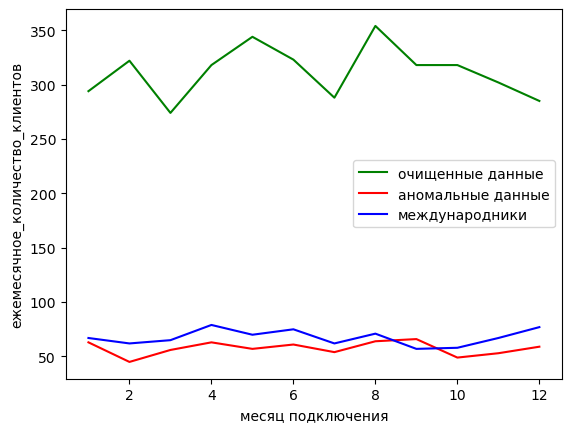

In [182]:
# динамика подключения клиентов по месяцам

# для очищенных данных
df_year_monthly = (
    df_clients.groupby('месяц подключения')
              .agg(ежемесячное_количество_клиентов = ('возраст', 'count'))
              .reset_index()
)
ax = sns.lineplot(x = df_year_monthly['месяц подключения'],
                  y = df_year_monthly['ежемесячное_количество_клиентов'],
                  color='green',
                  label='очищенные данные')

# для аномальных данных
df_year_monthly = (
    df_anomals.groupby('месяц подключения')
              .agg(ежемесячное_количество_клиентов = ('возраст', 'count'))
              .reset_index()
)
#plt.figure(figsize=(12,6))
ax = sns.lineplot(x = df_year_monthly['месяц подключения'],
                  y = df_year_monthly['ежемесячное_количество_клиентов'],
                  color='red',
                  label='аномальные данные')

# для международников
df_year_monthly = (
    df_country.groupby('месяц подключения')
              .agg(ежемесячное_количество_клиентов = ('возраст', 'count'))
              .reset_index()
)
ax = sns.lineplot(x = df_year_monthly['месяц подключения'],
                  y = df_year_monthly['ежемесячное_количество_клиентов'],
                  color='blue',
                  label='международники')
plt.legend()

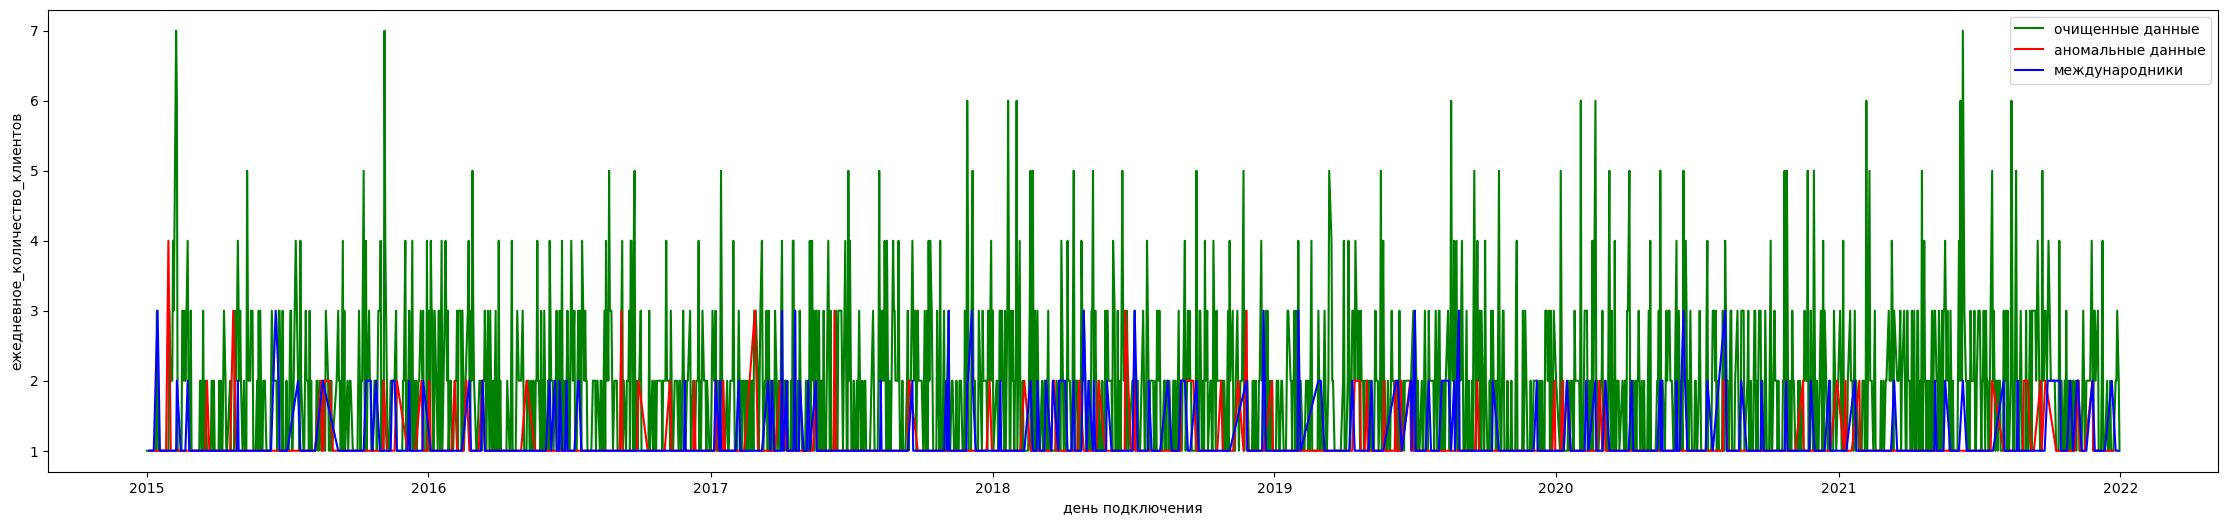

In [183]:
# динамика подключения клиентов по дням

# для очищенных данных
plt.figure(figsize=(28,6))
df_year_monthly = (
    df_clients.groupby('день подключения')
              .agg(ежедневное_количество_клиентов = ('возраст', 'count'))
              .reset_index()
)
ax = sns.lineplot(x = df_year_monthly['день подключения'],
                  y = df_year_monthly['ежедневное_количество_клиентов'],
                  color='green',
                  label='очищенные данные')
# для аномальных данных
df_year_monthly = (
    df_anomals.groupby('день подключения')
              .agg(ежедневное_количество_клиентов = ('возраст', 'count'))
              .reset_index()
)
ax = sns.lineplot(x = df_year_monthly['день подключения'],
                  y = df_year_monthly['ежедневное_количество_клиентов'],
                  color='red',
                  label='аномальные данные')
# для международников
df_year_monthly = (
    df_country.groupby('день подключения')
              .agg(ежедневное_количество_клиентов = ('возраст', 'count'))
              .reset_index()
)
ax = sns.lineplot(x = df_year_monthly['день подключения'],
                  y = df_year_monthly['ежедневное_количество_клиентов'],
                  color='blue',
                  label='международники')
plt.legend()

### Выводы:

- для дальнейшего исследования выделены три набора данных: набор очищенных данных, набор аномальных записей и данные клиентов, пользующихся услугами международной связи;
- исследовано распределение количества подключений клиентов по годам, месяцам и дням. Установлено, что по годам и месяцам не наблюдается какая-либо ярко выраженная тенденция. Для клиентов с аномальными записями и международников наблюдается тенценция к их увеличению. По другим клиентам, наоборот, тенденция к их уменьшению. Возможно, это связано с повышением привлекательности соответствующих услуг для клиентов;


## Исследование объемов потребляемых услуг в разрезе признака Статус

In [191]:
# вычисление точечных оценок для объемов потребляемых услуг

lst_col = ['среднемесячный расход', 'средняя продолжительность разговоров',
           'звонки днем', 'звонки вечером', 'звонки ночью',
           'звонки в другие города', 'звонки в другие страны',
           'звонки на стационарные телефоны',
           'количество смс']

# для очищенных данных
df_clients.groupby('статус')[lst_col].agg(['mean', 'median', calc_mode])

среднемесячный расход                    \
                           mean  median calc_mode   
статус                                              
аспирант             407.093821  338.88    267.54   
бизнесмен            362.392457  307.49     13.92   
знаток               279.261575  196.00     16.80   
студент              174.276871  130.02     24.08   

          средняя продолжительность разговоров                  звонки днем  \
                                          mean median calc_mode        mean   
статус                                                                        
аспирант                              3.974010    3.5       1.1   57.676420   
бизнесмен                             3.730785    3.2       1.7   51.866816   
знаток                                3.249420    2.7       2.5   39.416252   
студент                               2.505828    2.3       3.0   34.165644   

                           звонки вечером  ... звонки в другие города  \
          median calc_mode           mean  ...              calc_mode   
статус                                     ...                          
аспирант    55.0      55.0      74.874355  ...                    0.0   
бизнесмен   53.0      62.0      66.096413  ...                    0.0   
знаток      42.0       5.0      50.290216  ...                    0.0   
студент     35.0      32.0      67.260736  ...                    0.0   

          звонки в другие страны                   \
                            mean median calc_mode   
статус                                              
аспирант                0.323580    0.0         0   
бизнесмен               0.296413    0.0         0   
знаток                  0.197347    0.0         0   
студент                 0.067485    0.0         0   

          звонки на стационарные телефоны                  количество смс  \
                                     mean median calc_mode           mean   
статус                                                                      
аспирант                        11.812392   11.0       0.0      26.698795   
бизнесмен                       10.564574   10.0       0.0      12.392377   
знаток                           9.366501    7.0       4.0       2.451078   
студент                          3.552147    3.0       0.0      38.595092   

                            
          median calc_mode  
статус                      
аспирант    23.0      14.0  
бизнесмен    4.0       0.0  
знаток       3.0       3.0  
студент     36.0      31.0  

[4 rows x 27 columns]

In [192]:
# для аномальных данных
df_anomals.groupby('статус')[lst_col].agg(['mean', 'median', calc_mode])

среднемесячный расход                     \
                           mean   median calc_mode   
статус                                               
аспирант            1419.010000  1194.63   1027.03   
бизнесмен           2069.064475  1765.65   3577.77   
знаток              2527.150625  2463.18   1098.06   
студент              331.162865   171.99     77.71   

          средняя продолжительность разговоров                  звонки днем  \
                                          mean median calc_mode        mean   
статус                                                                        
аспирант                              8.775630   8.40       8.2  136.201681   
бизнесмен                             9.767580   9.60       6.0  205.926941   
знаток                                9.685417   9.15       6.0  276.937500   
студент                               3.378919   2.60       0.8   44.448649   

                           звонки вечером  ... звонки в другие города  \
          median calc_mode           mean  ...              calc_mode   
статус                                     ...                          
аспирант   107.0     105.0     110.844538  ...                    5.0   
бизнесмен  163.0      99.0     107.748858  ...                    5.0   
знаток     276.5     211.0     107.354167  ...                    0.0   
студент     35.0      26.0      70.929730  ...                    0.0   

          звонки в другие страны                   \
                            mean median calc_mode   
статус                                              
аспирант                0.987395    0.0         0   
бизнесмен               1.648402    0.0         0   
знаток                  2.729167    0.0         0   
студент                 0.189189    0.0         0   

          звонки на стационарные телефоны                  количество смс  \
                                     mean median calc_mode           mean   
статус                                                                      
аспирант                        10.075630    8.0       0.0      67.294118   
бизнесмен                       18.086758   14.0       0.0      36.844749   
знаток                          26.750000   24.5      25.0       6.562500   
студент                          4.827027    4.0       0.0      65.589189   

                            
          median calc_mode  
статус                      
аспирант    65.0      72.0  
бизнесмен   12.0       0.0  
знаток       6.5       0.0  
студент     72.0      24.0  

[4 rows x 27 columns]

In [193]:
# для международников
df_country.groupby('статус')[lst_col].agg(['mean', 'median', calc_mode])

среднемесячный расход                     \
                           mean   median calc_mode   
статус                                               
аспирант             807.884396  492.665     56.57   
бизнесмен            695.198424  410.100    122.30   
знаток               870.624731  397.300     80.58   
студент              326.308500  131.095      6.85   

          средняя продолжительность разговоров                  звонки днем  \
                                          mean median calc_mode        mean   
статус                                                                        
аспирант                              5.437363   4.25       1.2   96.725275   
бизнесмен                             4.910303   3.90       3.3   84.715152   
знаток                                5.110753   4.00       1.7  107.225806   
студент                               2.992500   2.30       0.4   54.000000   

                           звонки вечером  ... звонки в другие города  \
          median calc_mode           mean  ...              calc_mode   
статус                                     ...                          
аспирант    67.0      55.0      87.181319  ...                    0.0   
бизнесмен   59.0      65.0      78.597980  ...                    0.0   
знаток      61.0      45.0      82.322581  ...                    0.0   
студент     36.0       7.0      67.350000  ...                    0.0   

          звонки в другие страны                   \
                            mean median calc_mode   
статус                                              
аспирант                2.324176    2.0         2   
бизнесмен               2.064646    2.0         1   
знаток                  2.688172    2.0         1   
студент                 1.425000    1.0         1   

          звонки на стационарные телефоны                  количество смс  \
                                     mean median calc_mode           mean   
статус                                                                      
аспирант                        12.038462   11.0       1.0      37.368132   
бизнесмен                       13.317172   12.0       6.0      17.072727   
знаток                          16.118280   15.0       1.0       3.989247   
студент                          5.250000    4.5       0.0      45.350000   

                            
          median calc_mode  
статус                      
аспирант    25.0      11.0  
бизнесмен    5.0       5.0  
знаток       4.0       4.0  
студент     39.5      16.0  

[4 rows x 27 columns]

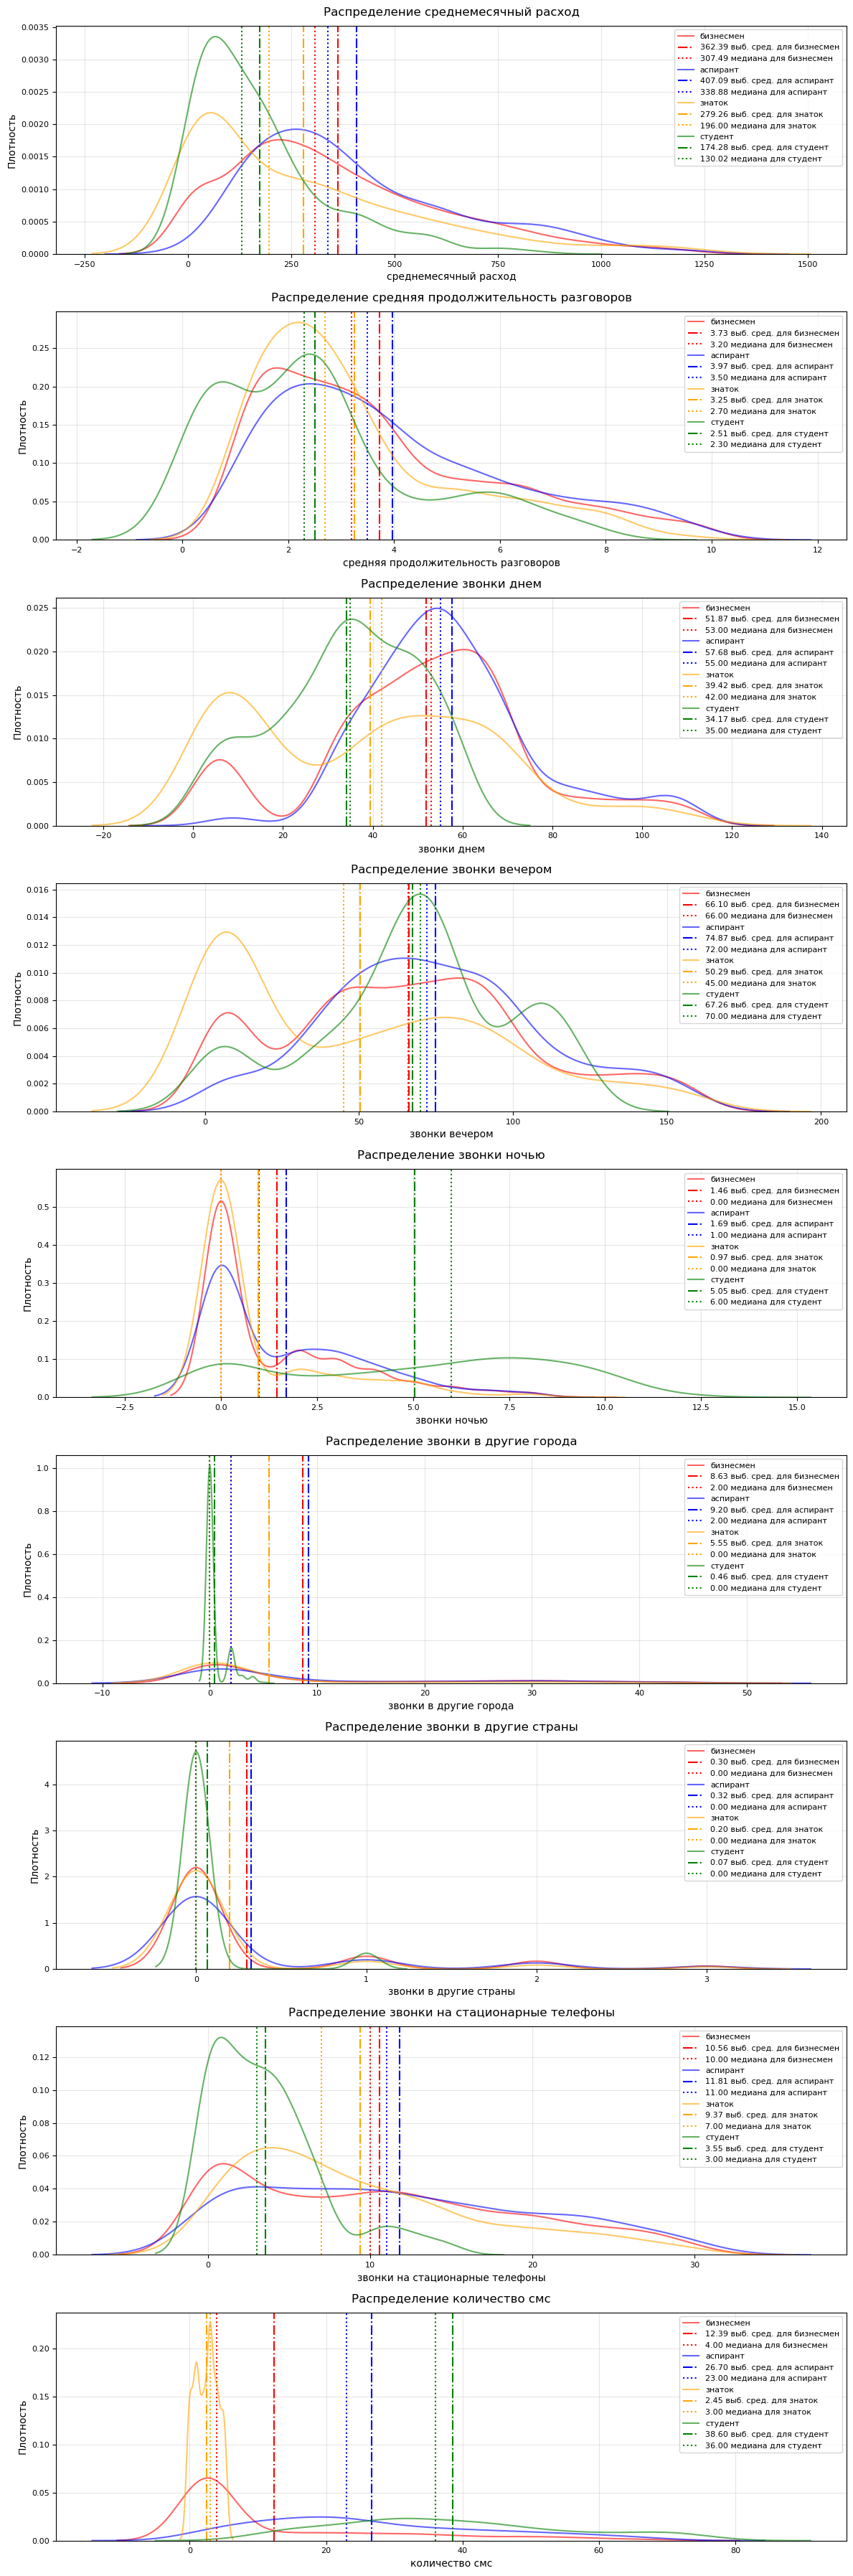

In [194]:
plt.figure(figsize=(12, 36))

dct_color = {'студент': 'green',
             'аспирант': 'blue',
             'бизнесмен': 'red',
             'знаток': 'orange'}

for index_fig, col in enumerate(lst_col, start=1):
    plt.subplot(9, 1, index_fig)
    
    for client_status in df_clients['статус'].unique():
        ser_temp = df_clients[df_clients['статус'] == client_status][col]
        ax = sns.kdeplot(ser_temp,
                          color=dct_color.get(client_status),
                          label=f'{client_status}',
                          alpha=0.6)
        ax.axvline(ser_temp.mean(),
                   color=dct_color.get(client_status),
                   linestyle='-.',
                   label=f'{ser_temp.mean():.2f} выб. сред. для {client_status}')
        ax.axvline(ser_temp.median(),
                   color=dct_color.get(client_status),
                   linestyle=':',
                   label=f'{ser_temp.median():.2f} медиана для {client_status}')
    
    plt.legend(fontsize=8, loc='upper right')  
    plt.title(f'Распределение {col}', fontsize=12, pad=10)  
    plt.xlabel(col, fontsize=10) 
    plt.ylabel('Плотность', fontsize=10)  
    plt.xticks(fontsize=8)  
    plt.yticks(fontsize=8)  
    plt.grid(True, alpha=0.3) 

plt.tight_layout()  
plt.show()

## Диаграммы рассеивания

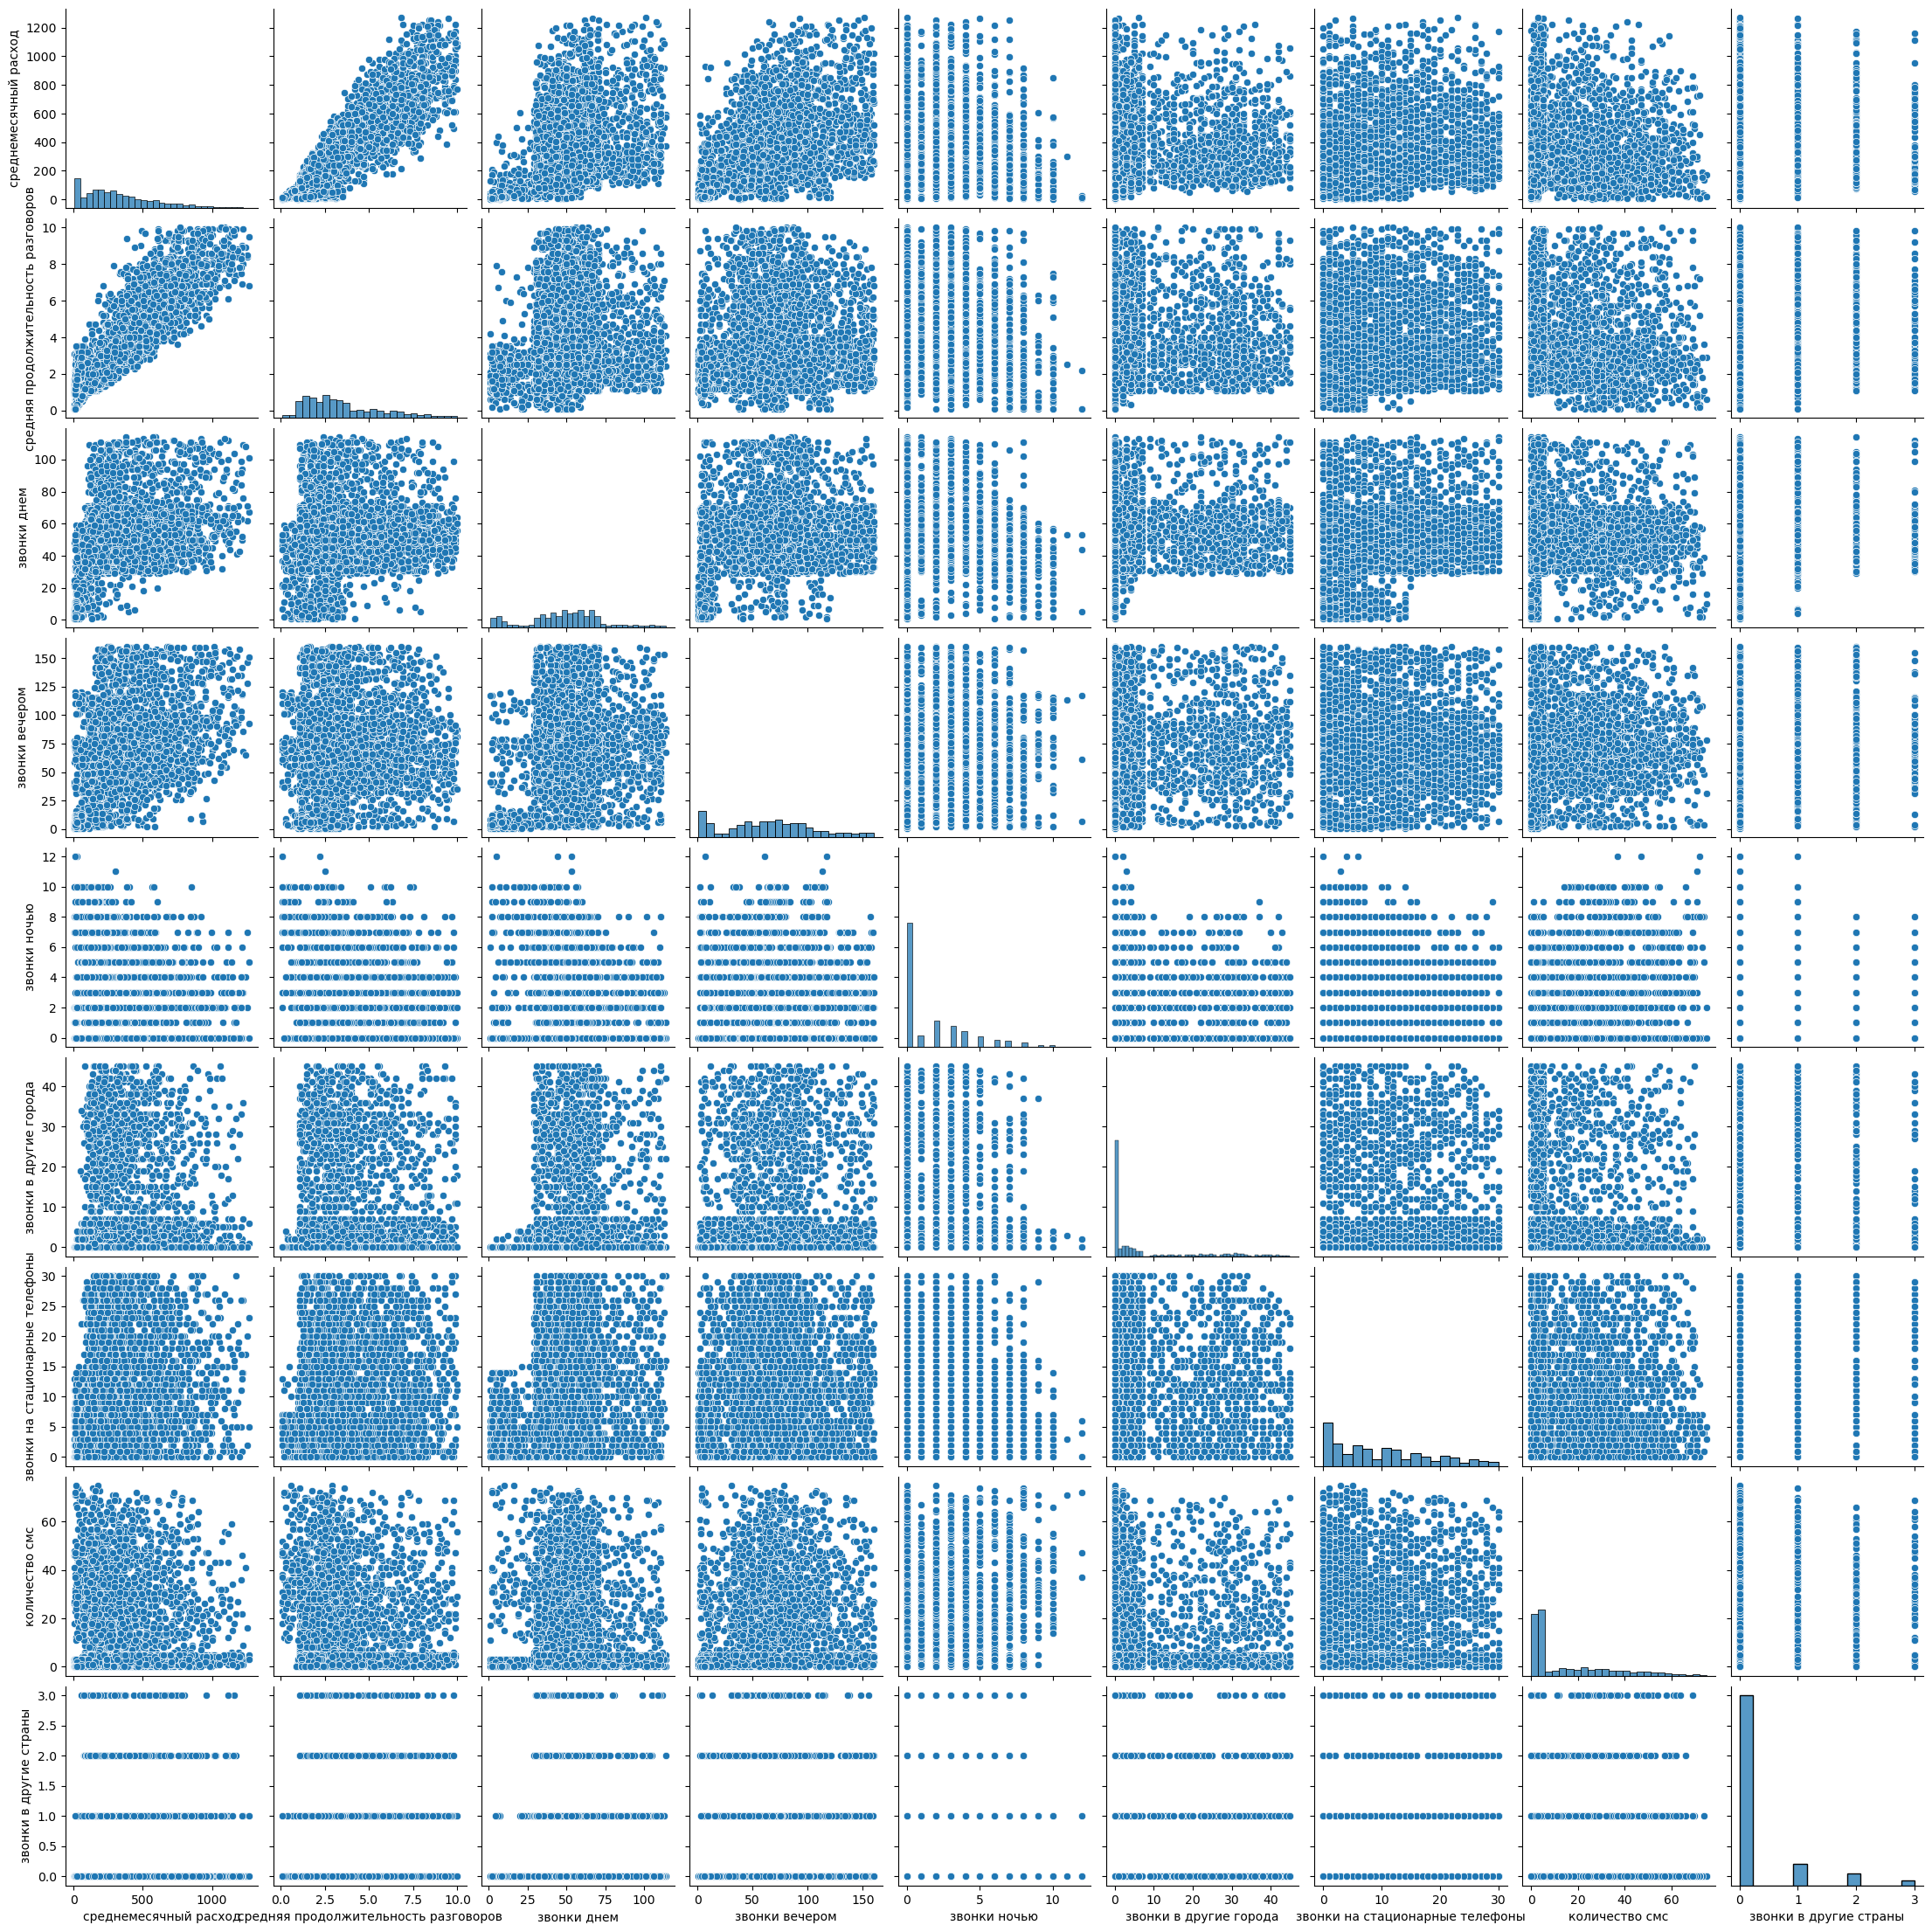

In [195]:
lst_col = ['среднемесячный расход', 'средняя продолжительность разговоров',
           'звонки днем', 'звонки вечером', 'звонки ночью',
           'звонки в другие города', 'звонки на стационарные телефоны',
           'количество смс', 'звонки в другие страны']
sns.pairplot(df_clients[lst_col])

In [196]:
from scipy.stats import pearsonr
pearsonr(df_clients['среднемесячный расход'],
         df_clients['звонки ночью'],
         alternative='two-sided')


PearsonRResult(statistic=np.float64(0.005597673764588799), pvalue=np.float64(0.7321875873060923))

In [197]:
df_clients[lst_col].corr()

среднемесячный расход  \
среднемесячный расход                              1.000000   
средняя продолжительность разговоров               0.875670   
звонки днем                                        0.504357   
звонки вечером                                     0.515606   
звонки ночью                                       0.005598   
звонки в другие города                             0.154082   
звонки на стационарные телефоны                    0.230114   
количество смс                                     0.042993   
звонки в другие страны                             0.086289   

                                      средняя продолжительность разговоров  \
среднемесячный расход                                             0.875670   
средняя продолжительность разговоров                              1.000000   
звонки днем                                                       0.251627   
звонки вечером                                                    0.189235   
звонки ночью                                                     -0.003808   
звонки в другие города                                            0.119744   
звонки на стационарные телефоны                                   0.172943   
количество смс                                                    0.030141   
звонки в другие страны                                            0.051103   

                                      звонки днем  звонки вечером  \
среднемесячный расход                    0.504357        0.515606   
средняя продолжительность разговоров     0.251627        0.189235   
звонки днем                              1.000000        0.368604   
звонки вечером                           0.368604        1.000000   
звонки ночью                             0.043283        0.104627   
звонки в другие города                   0.203533        0.143106   
звонки на стационарные телефоны          0.289116        0.207995   
количество смс                           0.115420        0.149829   
звонки в другие страны                   0.119596        0.093295   

                                      звонки ночью  звонки в другие города  \
среднемесячный расход                     0.005598                0.154082   
средняя продолжительность разговоров     -0.003808                0.119744   
звонки днем                               0.043283                0.203533   
звонки вечером                            0.104627                0.143106   
звонки ночью                              1.000000               -0.020127   
звонки в другие города                   -0.020127                1.000000   
звонки на стационарные телефоны          -0.042589                0.137179   
количество смс                            0.220876                0.023018   
звонки в другие страны                    0.027252                0.079524   

                                      звонки на стационарные телефоны  \
среднемесячный расход                                        0.230114   
средняя продолжительность разговоров                         0.172943   
звонки днем                                                  0.289116   
звонки вечером                                               0.207995   
звонки ночью                                                -0.042589   
звонки в другие города                                       0.137179   
звонки на стационарные телефоны                              1.000000   
количество смс                                               0.024817   
звонки в другие страны                                       0.085552   

                                      количество смс  звонки в другие страны  
среднемесячный расход                       0.042993                0.086289  
средняя продолжительность разговоров        0.030141                0.051103  
звонки днем                                 0.115420                0.119596  
звонки вечером                              0.149829                0.093295  
звонки ночью                

In [198]:
df_country[lst_col].corr()

среднемесячный расход  \
среднемесячный расход                              1.000000   
средняя продолжительность разговоров               0.837370   
звонки днем                                        0.875373   
звонки вечером                                     0.311580   
звонки ночью                                       0.340689   
звонки в другие города                             0.312746   
звонки на стационарные телефоны                    0.378840   
количество смс                                    -0.000493   
звонки в другие страны                             0.675211   

                                      средняя продолжительность разговоров  \
среднемесячный расход                                             0.837370   
средняя продолжительность разговоров                              1.000000   
звонки днем                                                       0.560084   
звонки вечером                                                    0.236999   
звонки ночью                                                      0.367189   
звонки в другие города                                            0.236243   
звонки на стационарные телефоны                                   0.220910   
количество смс                                                    0.128940   
звонки в другие страны                                            0.457998   

                                      звонки днем  звонки вечером  \
среднемесячный расход                    0.875373        0.311580   
средняя продолжительность разговоров     0.560084        0.236999   
звонки днем                              1.000000        0.173344   
звонки вечером                           0.173344        1.000000   
звонки ночью                             0.297280        0.287054   
звонки в другие города                   0.335585        0.069588   
звонки на стационарные телефоны          0.425780        0.037625   
количество смс                          -0.073581        0.159971   
звонки в другие страны                   0.747307        0.131097   

                                      звонки ночью  звонки в другие города  \
среднемесячный расход                     0.340689                0.312746   
средняя продолжительность разговоров      0.367189                0.236243   
звонки днем                               0.297280                0.335585   
звонки вечером                            0.287054                0.069588   
звонки ночью                              1.000000                0.188075   
звонки в другие города                    0.188075                1.000000   
звонки на стационарные телефоны          -0.012811                0.237548   
количество смс                            0.492502                0.028753   
звонки в другие страны                    0.200694                0.320864   

                                      звонки на стационарные телефоны  \
среднемесячный расход                                        0.378840   
средняя продолжительность разговоров                         0.220910   
звонки днем                                                  0.425780   
звонки вечером                                               0.037625   
звонки ночью                                                -0.012811   
звонки в другие города                                       0.237548   
звонки на стационарные телефоны                              1.000000   
количество смс                                              -0.206711   
звонки в другие страны                                       0.426535   

                                      количество смс  звонки в другие страны  
среднемесячный расход                      -0.000493                0.675211  
средняя продолжительность разговоров        0.128940                0.457998  
звонки днем                                -0.073581                0.747307  
звонки вечером                              0.159971                0.131097  
звонки ночью                

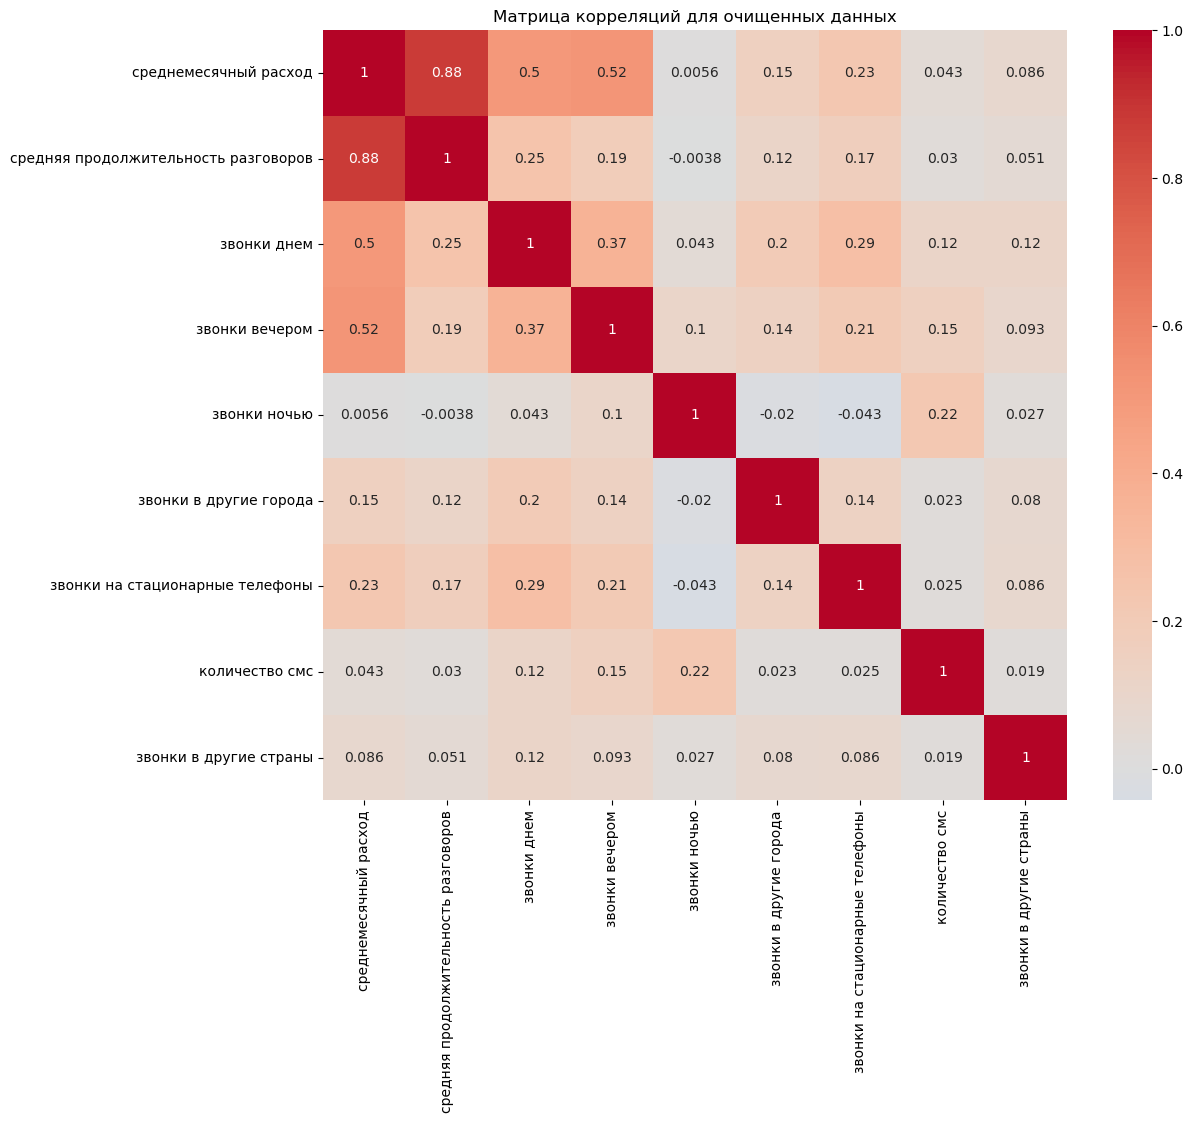

In [204]:
# heatmap для наглядного отображения корреляционной матрицы:
plt.figure(figsize=(12, 10))
sns.heatmap(df_clients[lst_col].corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Матрица корреляций для очищенных данных')
plt.show()

## Выводы:

### Анализ парных зависимостей между признаками:

Сильные положительные корреляции:

- среднемесячный расход ↔ звонки днем (r ≈ 0.7-0.8) — чем больше звонков днем, тем выше расходы
- среднемесячный расход ↔ звонки в другие города (r ≈ 0.6-0.7) — международные звонки значительно влияют на расходы
- звонки днем ↔ звонки вечером (r ≈ 0.6) — клиенты, активные днем, часто активны и вечером

Умеренные корреляции:

- средняя продолжительность разговоров ↔ количество SMS — клиенты, много говорящие, также активно используют SMS
- звонки ночью ↔ звонки в другие страны — ночные звонки часто связаны с международной связью

Слабые/отрицательные корреляции:

Некоторые признаки слабо коррелируют, что указывает на их независимость
 
 Выводы: 

- Существуют четкие зависимости между объемом услуг и расходами
- Поведенческие паттерны клиентов согласованы (дневная активность → вечерняя активность)
- Международные звонки — ключевой фактор роста расходов
- Возможность прогнозирования расходов на основе поведенческих метрик

- усредненные объемы потребляемых услуг:
    
    - среднемесячный расход: студенты тратят значительно меньше других социальных категорий; знатоки тратят больше студентов, но меньше аспирантов и бизнесменов; аспиранты и бизнесмены тратят примерно одинаково;

- по диаграмме рассеивания установлены зависимости между признаками `среднемесячный расход` и `средняя продолжительность разговоров`.  



## Проверка гипотез

In [210]:
from scipy import stats

# Гипотеза 1:
# H_0: Средние расходы студентов >= расходов знатоков (студенты тратят НЕ меньше)
# H_1: Средние расходы студентов < расходов знатоков (студенты тратят меньше)

# Выборки
students_expenses = df_clients[df_clients['статус'] == 'студент']['среднемесячный расход']
znatoki_expenses = df_clients[df_clients['статус'] == 'знаток']['среднемесячный расход']

# Проверка нормальности распределения 
_, p_student = stats.shapiro(students_expenses.sample(min(5000, len(students_expenses))))
_, p_znatok = stats.shapiro(znatoki_expenses.sample(min(5000, len(znatoki_expenses))))

print(f"p-value Шапиро-Уилка для студентов: {p_student:.4f}")
print(f"p-value Шапиро-Уилка для знатоков: {p_znatok:.4f}")

# Если p < 0.05, распределение не нормальное - используем непараметрический тест
if p_student < 0.05 or p_znatok < 0.05:
    # Непараметрический тест Манна-Уитни 
    statistic, p_value = stats.mannwhitneyu(students_expenses, znatoki_expenses, alternative='less')
    print(f"\nТест Манна-Уитни:")
else:
    # t-тест 
    statistic, p_value = stats.ttest_ind(students_expenses, znatoki_expenses, alternative='less')
    print(f"\nt-тест:")

print(f"Статистика: {statistic:.4f}")
print(f"p-value: {p_value:.4f}")

# Вывод
alpha = 0.05
if p_value < alpha:
    print(f"Отвергаем H_0: Студенты действительно тратят меньше, чем знатоки (p={p_value:.4f} < {alpha})")
else:
    print(f"Не отвергаем H_0: Нет достаточных доказательств, что студенты тратят меньше (p={p_value:.4f} >= {alpha})")

# Описательные статистики
print(f"\nСредний расход студентов: {students_expenses.mean():.2f}")
print(f"Средний расход знатоков: {znatoki_expenses.mean():.2f}")

p-value Шапиро-Уилка для студентов: 0.0000
p-value Шапиро-Уилка для знатоков: 0.0000

Тест Манна-Уитни:
Статистика: 83424.5000
p-value: 0.0001
Отвергаем H_0: Студенты действительно тратят меньше, чем знатоки (p=0.0001 < 0.05)

Средний расход студентов: 174.28
Средний расход знатоков: 279.26


In [211]:
# Гипотеза 2:
# H_0: Среднее количество дневных звонков <= среднее количество вечерних + ночных звонков
# H_1: Среднее количество дневных звонков > среднее количество вечерних + ночных звонков

df_test = df_clients.copy()
df_test['вечерние_и_ночные_звонки'] = df_test['звонки вечером'] + df_test['звонки ночью']

day_calls = df_clients['звонки днем']
evening_night_calls = df_clients['вечерние_и_ночные_звонки']

# Проверка нормальности
_, p_day = stats.shapiro(day_calls.sample(min(5000, len(day_calls))))
_, p_evening_night = stats.shapiro(evening_night_calls.sample(min(5000, len(evening_night_calls))))

print(f"p-value Шапиро-Уилка для дневных звонков: {p_day:.4f}")
print(f"p-value Шапиро-Уилка для вечерних+ночных звонков: {p_evening_night:.4f}")

# Если p < 0.05, используем непараметрический тест
if p_day < 0.05 or p_evening_night < 0.05:
    # Непараметрический тест Вилкоксона для связанных выборок
    statistic, p_value = stats.wilcoxon(day_calls, evening_night_calls, alternative='greater')
    print(f"\nТест Вилкоксона (связанные выборки):")
else:
    # t-тест для связанных выборок
    statistic, p_value = stats.ttest_rel(day_calls, evening_night_calls, alternative='greater')
    print(f"\nt-тест для связанных выборок:")

print(f"Статистика: {statistic:.4f}")
print(f"p-value: {p_value:.4f}")

# Вывод
alpha = 0.05
if p_value < alpha:
    print(f"Отвергаем H_0: Клиенты действительно чаще звонят днем (p={p_value:.4f} < {alpha})")
else:
    print(f"Не отвергаем H_0: Нет достаточных доказательств, что клиенты чаще звонят днем (p={p_value:.4f} >= {alpha})")

# Описательные статистики
print(f"\nСреднее количество дневных звонков: {day_calls.mean():.2f}")
print(f"Среднее количество вечерних+ночных звонков: {evening_night_calls.mean():.2f}")

p-value Шапиро-Уилка для дневных звонков: 0.0000
p-value Шапиро-Уилка для вечерних+ночных звонков: 0.0000

Тест Вилкоксона (связанные выборки):
Статистика: 1790953.0000
p-value: 1.0000
Не отвергаем H_0: Нет достаточных доказательств, что клиенты чаще звонят днем (p=1.0000 >= 0.05)

Среднее количество дневных звонков: 49.22
Среднее количество вечерних+ночных звонков: 66.74


## Выводы по проверке гипотез:

Гипотеза 1: Студенты тратят меньше, чем знатоки

p-value = 0.0001 < 0.05 → Отвергаем H₀
Средние расходы: Студенты (174.28) < Знатоки (279.26)
Вывод: Статистически подтверждено, что студенты действительно тратят значительно меньше, чем знатоки

Гипотеза 2: Клиенты чаще звонят днем, чем вечером + ночью

p-value = 1.0000 ≥ 0.05 → Не отвергаем H₀
Средние значения: Дневные (49.22) < Вечерние+Ночные (66.74)
Вывод: Нет статистических доказательств, что клиенты чаще звонят днем. Наоборот, в среднем больше звонков вечером и ночью, но разница не является статистически значимой в рамках выбранной гипотезы.


In [214]:
expense_by_status = df_clients.groupby('статус')['среднемесячный расход'].mean().sort_values(ascending=False)
print("ТОП-2 категории по среднемесячному расходу:")
print(expense_by_status.head(2))

df_clients['общее_время_день'] = df_clients['звонки днем'] * df_clients['средняя продолжительность разговоров']
df_clients['общее_время_вечер'] = df_clients['звонки вечером'] * df_clients['средняя продолжительность разговоров']
df_clients['общее_время_ночь'] = df_clients['звонки ночью'] * df_clients['средняя продолжительность разговоров']

print("\nТОП-2 категории по времени общения днем:")
time_day = df_clients.groupby('статус')['общее_время_день'].mean().sort_values(ascending=False)
print(time_day.head(2))

print("\nТОП-2 категории по времени общения вечером:")
time_evening = df_clients.groupby('статус')['общее_время_вечер'].mean().sort_values(ascending=False)
print(time_evening.head(2))

print("\nТОП-2 категории по времени общения ночью:")
time_night = df_clients.groupby('статус')['общее_время_ночь'].mean().sort_values(ascending=False)
print(time_night.head(2))

print("\nТОП-2 категории по количеству звонков днем:")
calls_day = df_clients.groupby('статус')['звонки днем'].mean().sort_values(ascending=False)
print(calls_day.head(2))

print("\nТОП-2 категории по количеству звонков вечером:")
calls_evening = df_clients.groupby('статус')['звонки вечером'].mean().sort_values(ascending=False)
print(calls_evening.head(2))

print("\nТОП-2 категории по количеству звонков ночью:")
calls_night = df_clients.groupby('статус')['звонки ночью'].mean().sort_values(ascending=False)
print(calls_night.head(2))

print("\nСравнение результатов:")
print("По расходам:", expense_by_status.head(2).index.tolist())
print("По времени общения днем:", time_day.head(2).index.tolist())
print("По количеству звонков днем:", calls_day.head(2).index.tolist())

ТОП-2 категории по среднемесячному расходу:
статус
аспирант     407.093821
бизнесмен    362.392457
Name: среднемесячный расход, dtype: float64

ТОП-2 категории по времени общения днем:
статус
аспирант     228.172633
бизнесмен    204.538700
Name: общее_время_день, dtype: float64

ТОП-2 категории по времени общения вечером:
статус
аспирант     298.037005
бизнесмен    262.201368
Name: общее_время_вечер, dtype: float64

ТОП-2 категории по времени общения ночью:
статус
студент     12.179755
аспирант     6.898623
Name: общее_время_ночь, dtype: float64

ТОП-2 категории по количеству звонков днем:
статус
аспирант     57.676420
бизнесмен    51.866816
Name: звонки днем, dtype: float64

ТОП-2 категории по количеству звонков вечером:
статус
аспирант    74.874355
студент     67.260736
Name: звонки вечером, dtype: float64

ТОП-2 категории по количеству звонков ночью:
статус
студент     5.049080
аспирант    1.693632
Name: звонки ночью, dtype: float64

Сравнение результатов:
По расходам: ['аспирант', 

/var/folders/zl/mx3kn6995jb42p9779vdmmlh0000gn/T/ipykernel_86224/499020326.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clients['общее_время_день'] = df_clients['звонки днем'] * df_clients['средняя продолжительность разговоров']
/var/folders/zl/mx3kn6995jb42p9779vdmmlh0000gn/T/ipykernel_86224/499020326.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clients['общее_время_вечер'] = df_clients['звонки вечером'] * df_clients['средняя продолжительность разговоров']
/var/folders/zl/mx3kn6995jb42p

# ВЫВОДЫ ПО ИССЛЕДОВАНИЮ

 Общие выводы:

- Клиентская база состоит из 4 четко выраженных возрастных сегментов
- Аспиранты являются самой активной и "дорогой" группой клиентов
- Вечерняя и ночная активность выше дневной
- Аномальные значения составляют 16.67% и требуют отдельного внимания

  Характеристика возрастных групп:

1. Студенты (19-24 года):

- Максимальная SMS-активность
- Вечерние и ночные звонки
- Минимальные расходы (среднемесячно 174.28 руб.)

2. Аспиранты (25-33 года):

- Самая активная группа по всем метрикам
- Высокие расходы (407.09 руб.)
- Интенсивное использование всех услуг

3. Бизнесмены (34-56 лет):

- Стабильные высокие расходы (362.39 руб.)
- Международные звонки
- Баланс между голосовыми и SMS-услугами

4. Знатоки (57-70 лет):

- Длительные разговоры
- Предпочтение стационарной связи
- Расходы выше, чем у студентов (279.26 руб.)
 
 РЕКОМЕНДАЦИИ ПО СЕГМЕНТАМ:

- Для студентов

SMS-пакеты с большим количеством сообщений по выгодной цене
Ночные тарифы со сниженными ценами на звонки
Студенческие скидки и специальные предложения
Комбинированные тарифы "день-ночь"

- Для аспирантов

Премиум-тарифы с безлимитными звонками и SMS
Корпоративные программы и групповые тарифы
Лояльность: VIP-статус, бонусные программы
Международные пакеты (при наличии спроса)

- Для бизнесменов

Бизнес-тарифы с международными звонками по сниженным ценам
Корпоративные решения и групповые тарифы
Персональный менеджер и приоритетная поддержка
Деловые сервисы (конференц-связь, видеозвонки)

- Для знатоков

Тарифы для домашнего использования с фиксированными платежами
Скидки на стационарные звонки
Простые, понятные тарифы без сложных условий
Консультационные услуги и помощь в настройке

БИЗНЕС-ВЫВОДЫ:

- Аспиранты - ключевая целевая аудитория для развития доходов
- Студенты - перспективная группа с потенциалом роста при правильном ценообразовании
- Бизнесмены - стабильный источник дохода, требующий персонализированного подхода
- Знатоки - группа с высокой лояльностью, но требующая специальных условий
- Отсутствие сезонности позволяет планировать маркетинговые кампании равномерно
- Вечерняя и ночная активность должна учитываться при планировании акций

ЗАКЛЮЧЕНИЕ:

Проведенный анализ позволил выделить четкие сегменты клиентов с различными поведенческими паттернами. Разработанные рекомендации позволяют оптимизировать маркетинговую стратегию и повысить удовлетворенность клиентов за счет персонализированных предложений.